 ---
 ## Cancer Image Classification using Pytorch
 ---

In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from PIL import Image
from itertools import accumulate
%matplotlib inline

import cv2
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset,random_split
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

In [2]:
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'
train_label = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'

In [3]:
print('Train set: {}'.format(len(os.listdir(train_dir))))
print('Test set: {}'.format(len(os.listdir(test_dir))))

Train set: 220025
Test set: 57458


In [4]:
labels_df = pd.read_csv(train_label)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [5]:
label_count = labels_df['label'].value_counts()
label_count

label
0    130908
1     89117
Name: count, dtype: int64

---
## Data Exploration
---

<Axes: ylabel='count'>

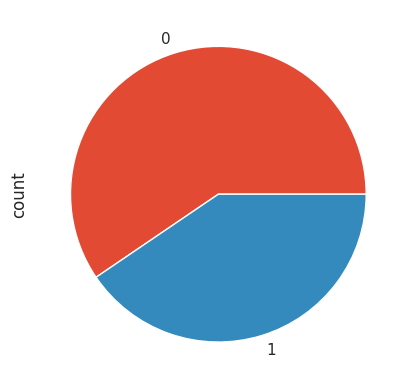

In [6]:
labels_df["label"].value_counts().plot(kind="pie")

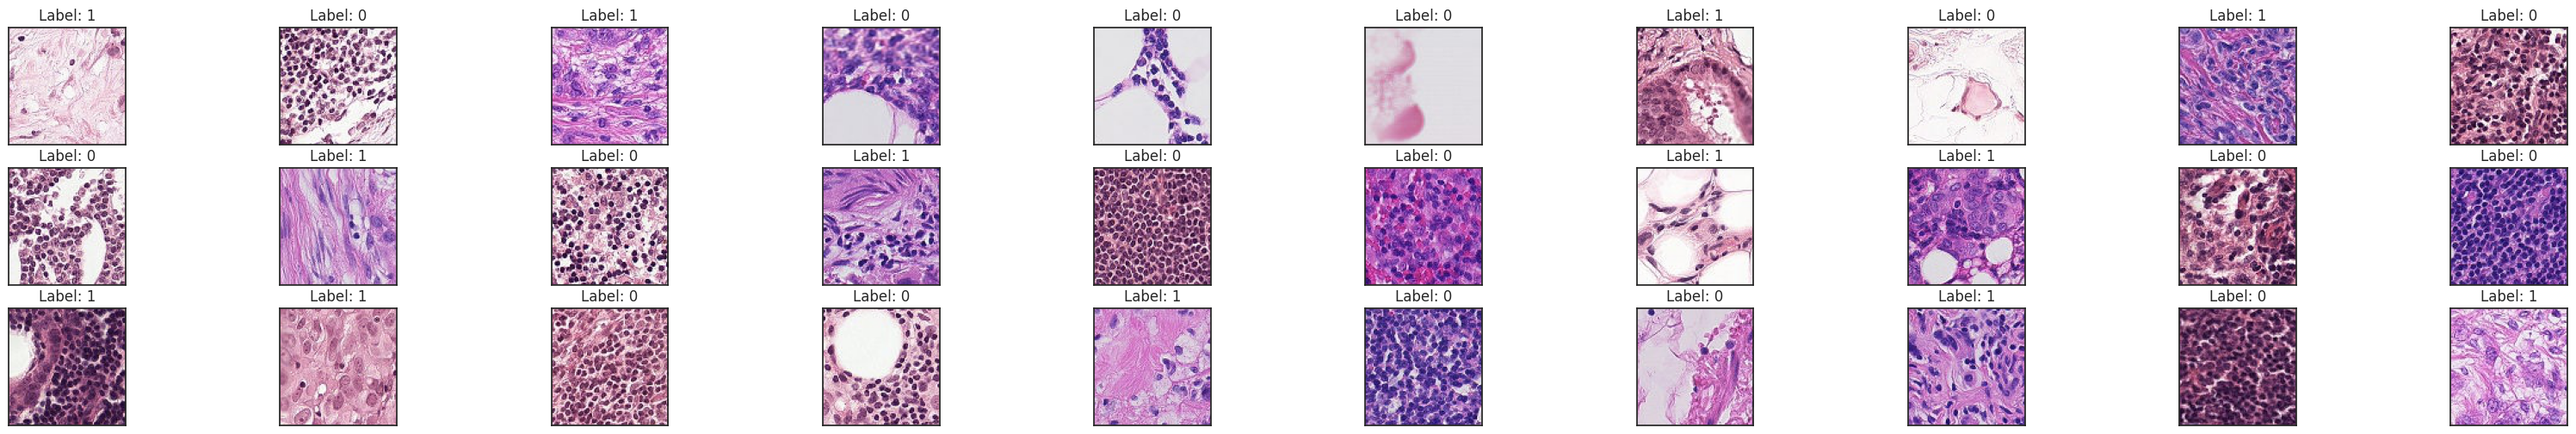

In [7]:
fig = plt.figure(figsize=(40, 6))
for idx, img in enumerate(np.random.choice(os.listdir(train_dir), 30)):
    ax = fig.add_subplot(3, 30//3, idx+1, xticks=[], yticks=[])
    im = Image.open(train_dir + img)
    plt.imshow(im)
    lab = labels_df.loc[labels_df['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title('Label: %s'%lab)

---
## Sampling
---

In [8]:
SAMPLE_SIZE = 80000
df_neg = labels_df[labels_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_pos = labels_df[labels_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)
# Concatenate the two dfs and shuffle them up
train_df = sklearn.utils.shuffle(pd.concat([df_pos, df_neg], axis=0).reset_index(drop=True))

train_df.shape

(160000, 2)

In [9]:
train_df.head()

,id,label
132701,79874dd1b45ad26a2fc3fc616a0f81f83d0b21aa,0
140365,507ce639c7710886441e3cf8e7494b1b7644d255,0
19761,3e6632c790e022b94e66ed75fb12b80aa2d70c12,1
98921,3b66dec9eb82d58f4a08f745bdce66995a9a3d8d,0
11600,fd91fff6ea4480c713426bc310f64feca19ed91e,1


---
## Data Preparation
---

In [10]:
batch_size = 128
valid_size = 0.1

In [11]:
# Our own custom class for datasets
class TorchPrep(Dataset):
    def __init__(self, df_data, data_dir = './', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
   

In [12]:
train_path = '/kaggle/input/histopathologic-cancer-detection/train/'
test_path = '/kaggle/input/histopathologic-cancer-detection/test/'

transforms_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [13]:
train_data = TorchPrep(df_data=train_df, data_dir=train_path, transform=transforms_train)

In [14]:
# load an example tensor
img,label=train_data[10]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 96, 96]) tensor(-1.) tensor(1.)


In [15]:
train_data

---
## Prepare DataLoader
---

In [16]:
num_train = len(train_data)
indices = list(range(num_train))
# np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [17]:
# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [18]:
# For the validation dataset, we don't need any augmentation; simply convert images into tensors
val_transf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# creating test data
sample_sub = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
test_data = TorchPrep(df_data=sample_sub, data_dir=test_dir, transform=val_transf)

# After defining the transformations, overwrite the transform functions of train_ts, val_ts
# prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

---
## Defining our CNN
---

In [19]:
import torch.nn.functional as F
class CovNet(nn.Module):
    def __init__(self):
        """
        """
        super(CovNet, self).__init__()
        self.conv1=nn.Sequential(nn.Conv2d(3,32,3,1,0),nn.BatchNorm2d(32),nn.ReLU(inplace=True),nn.MaxPool2d(2,2))
        self.conv2=nn.Sequential(nn.Conv2d(32,64,2,1,1),nn.BatchNorm2d(64),nn.ReLU(inplace=True),nn.MaxPool2d(2,2))
        self.conv3=nn.Sequential(nn.Conv2d(64,128,3,1,1),nn.BatchNorm2d(128),nn.ReLU(inplace=True),nn.MaxPool2d(2,2))
        self.conv4=nn.Sequential(nn.Conv2d(128,256,3,1,1),nn.BatchNorm2d(256),nn.ReLU(inplace=True),nn.MaxPool2d(2,2))
        self.conv5=nn.Sequential(nn.Conv2d(256,512,3,1,1),nn.BatchNorm2d(512),nn.ReLU(inplace=True),nn.MaxPool2d(2,2))
        self.dropout = nn.Dropout()
        self.fc = nn.Sequential(nn.Linear(512*3*3,1024),
                                nn.ReLU(inplace=True),
                                nn.Dropout(0.4),
                                nn.Linear(1024,512),
                                nn.Dropout(0.4),
                                nn.Linear(512, 1),
                                nn.Sigmoid())
                                
        
    def forward(self, x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=self.conv3(x)
        x=self.conv4(x)
        x=self.conv5(x)
        #print(x.shape) 
        x=x.view(x.shape[0],-1)
        x=self.fc(x)
        return x
     

In [20]:
train_on_gpu = torch.cuda.is_available()

In [21]:
model = CovNet()
print(model)
if train_on_gpu:
    model.cuda()

CovNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [22]:
# specify loss function (categorical cross-entropy loss)
criterion = nn.BCELoss()
# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00015)

In [23]:
print(model.parameters())
print(len(list(model.parameters())))
print(list(model.parameters())[4].size())
print(list(model.parameters())[0].size())

<generator object Module.parameters at 0x786ef34736f0>
26
torch.Size([64, 32, 2, 2])
torch.Size([32, 3, 3, 3])


In [24]:
# number of epochs to train the model
n_epochs = 5

valid_loss_min = np.Inf

# keeping track of losses as it happen
train_losses = []
valid_losses = []
val_auc = []
test_accuracies = []
valid_accuracies = []
auc_epoch = []

for epoch in range(1, n_epochs + 1):
    val_auc = []
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    predictions = []
    true_labels = []
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        target = target.view(-1, 1)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # Update Train loss and accuracies
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda().float()
        # forward pass: compute predicted outputs by passing inputs to the model
        target = target.view(-1, 1)
        output = model(data)
        # accumulate predictions and true labels
        true_labels.append(target.cpu().numpy())
        predictions.append(output[:, -1].detach().cpu().numpy())
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        #output = output.topk()
        y_actual = target.data.cpu().numpy()
        y_pred = output[:,-1].detach().cpu().numpy()
        val_auc.append(roc_auc_score(y_actual, y_pred))        
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_auc = np.mean(val_auc)
    auc_epoch.append(np.mean(val_auc))
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # Calculate additional metrics
    y_true = np.concatenate(true_labels)
    y_pred = np.concatenate(predictions)
    
    accuracy = accuracy_score(y_true, (y_pred > 0.5).astype(int))
    precision = precision_score(y_true, (y_pred > 0.5).astype(int))
    recall = recall_score(y_true, (y_pred > 0.5).astype(int))
    f1 = f1_score(y_true, (y_pred > 0.5).astype(int))
    
    # print training/validation statistics 
    print('Epoch: {} | Training Loss: {:.6f} | Validation Loss: {:.6f} | Validation AUC: {:.4f} | '
          'Accuracy: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1 Score: {:.4f}'.format(
        epoch, train_loss, valid_loss, valid_auc, accuracy, precision, recall, f1))

    
    ##################
    # Early Stopping #
    ##################
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | Training Loss: 0.367401 | Validation Loss: 0.328558 | Validation AUC: 0.9462 | Accuracy: 0.8662 | Precision: 0.8299 | Recall: 0.9211 | F1 Score: 0.8731
Validation loss decreased (inf --> 0.328558).  Saving model ...
Epoch: 2 | Training Loss: 0.291813 | Validation Loss: 0.275750 | Validation AUC: 0.9623 | Accuracy: 0.8862 | Precision: 0.8481 | Recall: 0.9408 | F1 Score: 0.8921
Validation loss decreased (0.328558 --> 0.275750).  Saving model ...
Epoch: 3 | Training Loss: 0.255466 | Validation Loss: 0.261340 | Validation AUC: 0.9611 | Accuracy: 0.8888 | Precision: 0.9313 | Recall: 0.8394 | F1 Score: 0.8830
Validation loss decreased (0.275750 --> 0.261340).  Saving model ...
Epoch: 4 | Training Loss: 0.231957 | Validation Loss: 0.243602 | Validation AUC: 0.9716 | Accuracy: 0.8989 | Precision: 0.8587 | Recall: 0.9547 | F1 Score: 0.9042
Validation loss decreased (0.261340 --> 0.243602).  Saving model ...
Epoch: 5 | Training Loss: 0.216185 | Validation Loss: 0.201671 | Validation A

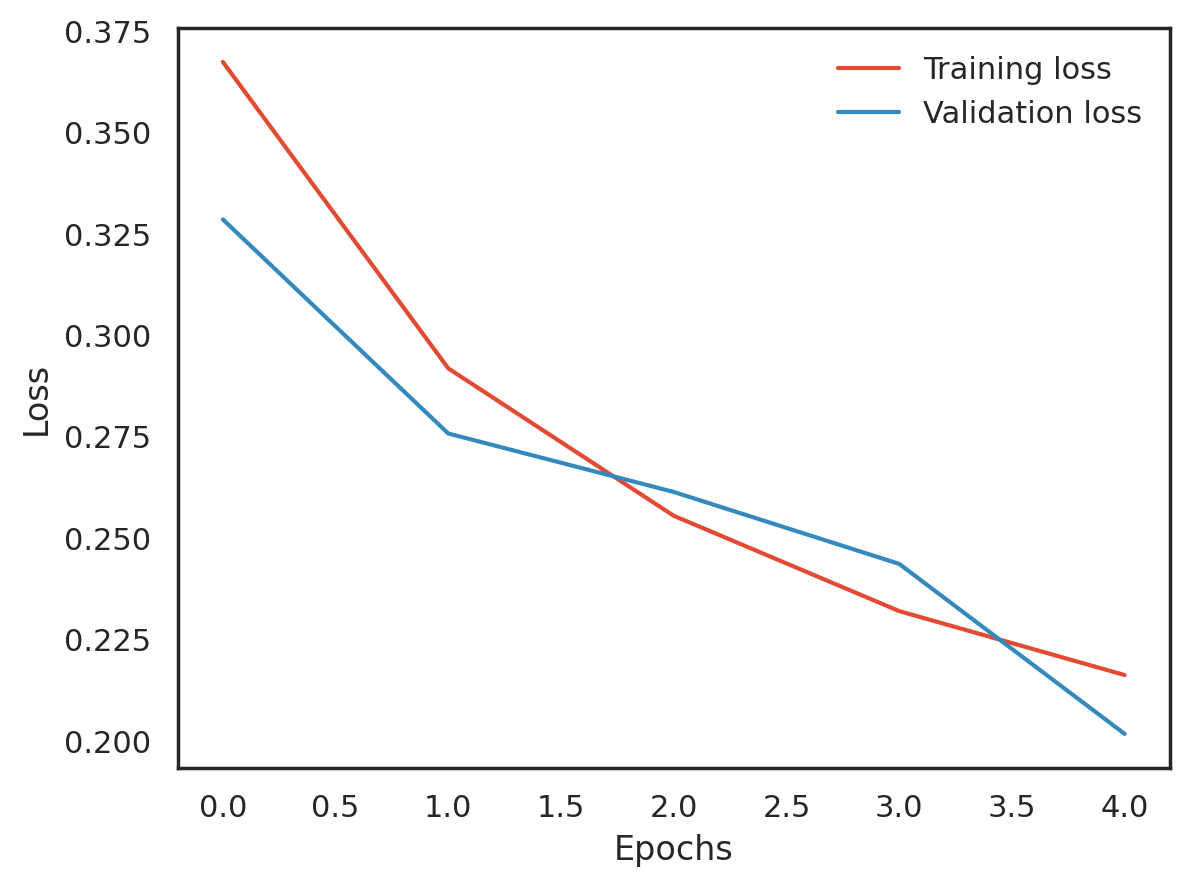

In [26]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

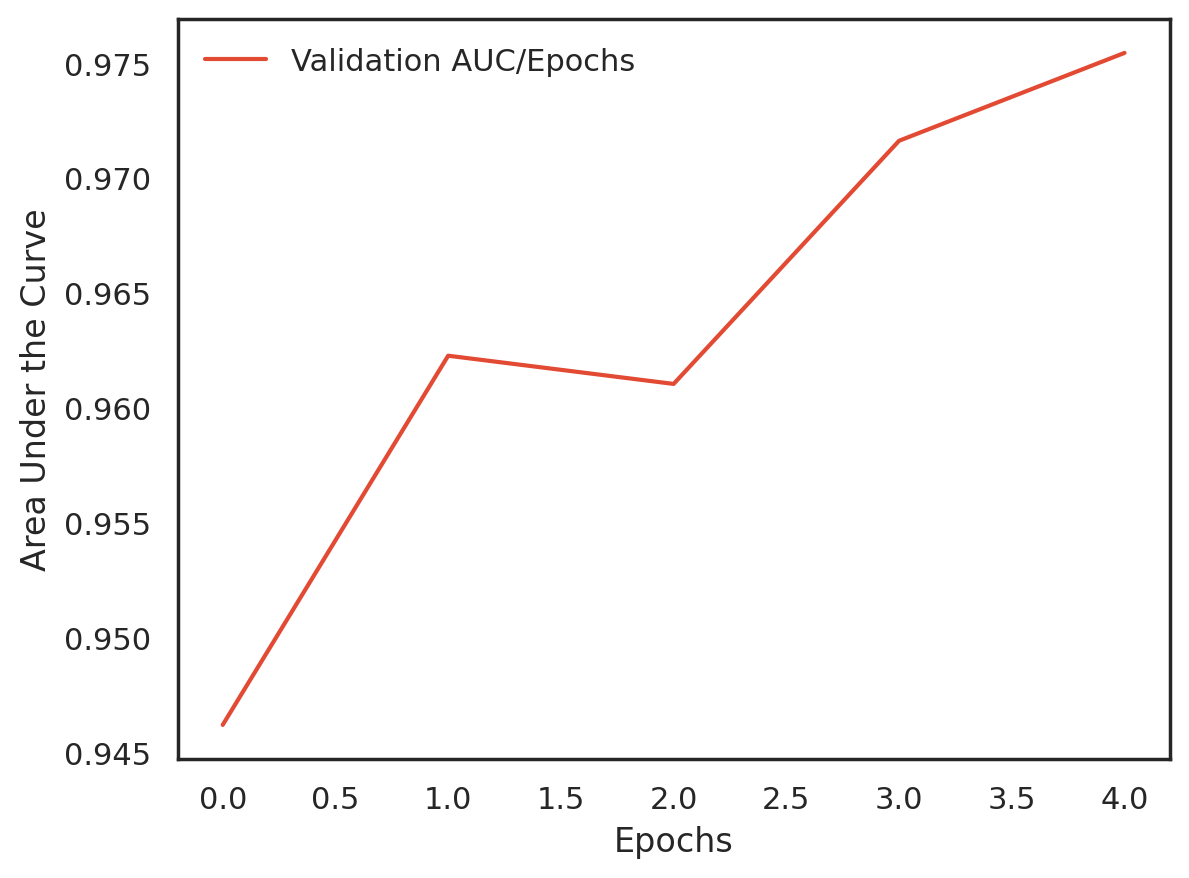

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(auc_epoch, label='Validation AUC/Epochs')
plt.legend("")
plt.xlabel("Epochs")
plt.ylabel("Area Under the Curve")
plt.legend(frameon=False)